# Introduction :
Dans ce mini projet, il est demandé de faire la classification des images de l’ensemble de données Alzaheimer.

## Présentation de l’ensemble de données :
Notre ensemble de données se compose d’images IRM qui sont utilisées pour la classification des images du cerveau car elles offrent des informations détaillées sur les structures anatomiques du cerveau avec une excellente résolution spatiale. Les données ont quatre classes d’images à la fois en entrainement ainsi qu’un ensemble de tests :
    (**Mild Demented**, **Moderate Demented**, **Non Demented**, et **Very Mild Demented**)
    
Les images IRM sont utilisées pour la classification des images du cerveau car elles offrent des informations détaillées sur les structures anatomiques du cerveau avec une excellente résolution spatiale.
L’ensemble de données se compose de deux fichiers - Train et Tests contenant chacun un total d’environ 5 000 images séparées en fonction de la sévérité de la maladie d’Alzheimer.

**1. Install Dependencies and Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from sklearn import preprocessing
import random
import tensorflow as tf

In [2]:
!pip install visualkeras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 15.1 MB/s eta 0:00:00


In [3]:
#To check if i am working on my gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Loading and Preparing Data**

In [5]:
from sklearn.preprocessing import OneHotEncoder

data_dir = '/content/drive/MyDrive/Data/Alzheimer/'

width = 32
height = 32
classes = 4
data_image = []
label_image = []
df = pd.DataFrame(columns=['Image Location','Label'])


#Read all the images exist in Alzheimer folder and put the images after resizing and processing them in the list data image and their labels in label images
#Also put their path in a dataframe named df

for Dir in os.listdir(data_dir):
    for Class in os.listdir(data_dir+Dir):
       for location in os.listdir(data_dir+Dir+'/'+Class+'/'):
          img_path = os.path.join(data_dir+Dir+'/'+Class+'/'+location)
          df = df.append({'Image Location': img_path,'Label':Class},ignore_index=True)
          img = cv2.imread(img_path)
          img = cv2.resize(img, (width,height))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
          data_image.append(img)
          label_image.append(Class)


X = np.array(data_image)
y = np.array(label_image)
y = y.reshape(y.shape[0],1) 




## OneHotEncoder
***We have to convert categorical variables into a format that can be provided to our algorithm
The encoder creates a new binary column for each category in the input data, with a value of 1 indicating the presence of the category in a given row and 0 indicating its absence.***

In [6]:
#Encode categorical features as a one-hot numeric array
#change the class from name to vector exemple :  from "MildDemented" to [0 0 0 1]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)
print(enc.categories_)
y = enc.transform(y).toarray()


print('Image data size  :   '+str(X.shape))
print('Image label size :   '+str(y.shape))
    

[array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')]
Image data size  :   (6400, 32, 32)
Image label size :   (6400, 4)


In [7]:
df.head()

,Image Location,Label
0,/content/drive/MyDrive/Data/Alzheimer/test/Ver...,VeryMildDemented
1,/content/drive/MyDrive/Data/Alzheimer/test/Ver...,VeryMildDemented
2,/content/drive/MyDrive/Data/Alzheimer/test/Ver...,VeryMildDemented
3,/content/drive/MyDrive/Data/Alzheimer/test/Ver...,VeryMildDemented
4,/content/drive/MyDrive/Data/Alzheimer/test/Ver...,VeryMildDemented


In [8]:
df2 = df.pivot_table(index = ['Label'], aggfunc ='size')
print(df2)


Label
MildDemented         896
ModerateDemented      64
NonDemented         3200
VeryMildDemented    2240
dtype: int64


In [ ]:
data = dict(df2)
labels = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='blue',width = 0.4)
 
plt.xlabel("Labels")
plt.ylabel("Number of MRI images")
plt.title("Number of MRI images by label")
plt.show()

In [ ]:
#to plot from each of the 4 labels one image
count = 1 # which plot i am in

fig = plt.figure(figsize=(40,15))

for Class in df['Label'].unique():
    seg = df[df['Label'] == Class]
    address =  seg.sample().iloc[0]['Image Location']
    img = cv2.imread(address)
    ax = fig.add_subplot(1, 4,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1

plt.suptitle("Alzheimer Classifications", size = 50)
plt.show()

**3. Splitting The Data**

In [11]:
from sklearn.model_selection import train_test_split

#Splitting The Data into training data with size 75% and testing data with size 25% of the hall dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print('Train data  : '+str(X_train.shape))
print('Train label : '+str(y_train.shape))
print('Test data   : '+str(X_test.shape))
print('Test label  : '+str(y_test.shape))

Train data  : (4800, 32, 32)
Train label : (4800, 4)
Test data   : (1600, 32, 32)
Test label  : (1600, 4)


4. Building the CNN model


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation=tf.nn.relu, input_shape=(32, 32, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(128, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),

    tf.keras.layers.Conv2D(256, (2,2), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    Dropout(0.3),
                    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4,  activation=tf.nn.softmax)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

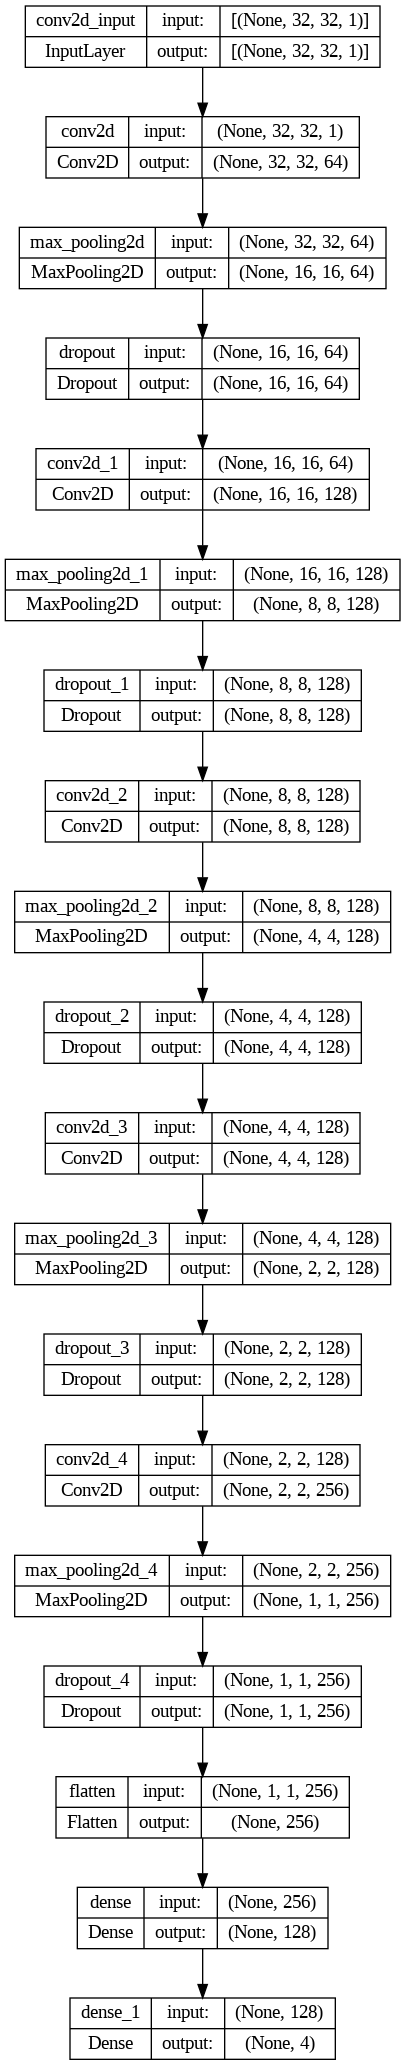

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

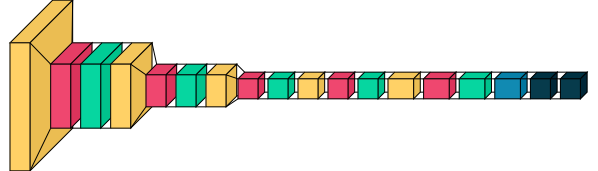

In [15]:
import visualkeras

visualkeras.layered_view(model)

**5. Training The Model**

In [16]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
hist = model.fit(X_train, y_train, epochs=300, validation_split=0.3, batch_size=20,verbose=1,shuffle=True)

Epoch 1/300
168/168 [==============================] - 11s 7ms/step - loss: 1.8095 - accuracy: 0.4601 - val_loss: 1.1110 - val_accuracy: 0.5007
Epoch 2/300
168/168 [==============================] - 1s 6ms/step - loss: 1.0485 - accuracy: 0.4935 - val_loss: 1.1094 - val_accuracy: 0.5007
Epoch 3/300
168/168 [==============================] - 1s 8ms/step - loss: 1.0298 - accuracy: 0.4777 - val_loss: 0.9373 - val_accuracy: 0.5278
Epoch 4/300
168/168 [==============================] - 1s 8ms/step - loss: 1.0327 - accuracy: 0.4902 - val_loss: 0.9700 - val_accuracy: 0.5035
Epoch 5/300
168/168 [==============================] - 1s 6ms/step - loss: 1.0068 - accuracy: 0.5116 - val_loss: 0.9691 - val_accuracy: 0.5958
Epoch 6/300
168/168 [==============================] - 1s 7ms/step - loss: 0.9807 - accuracy: 0.5256 - val_loss: 1.0800 - val_accuracy: 0.4181
Epoch 7/300
168/168 [==============================] - 1s 7ms/step - loss: 0.9557 - accuracy: 0.5330 - val_loss: 0.8855 - val_accuracy: 0.605

**6. Plotting The Performance**

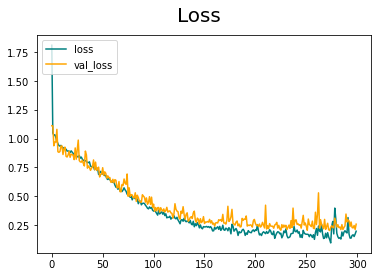

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

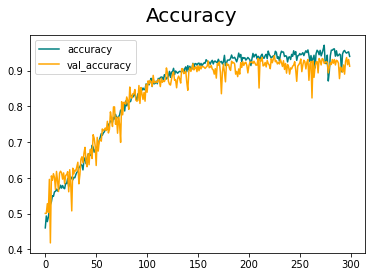

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**7. Evaluating The Model**

In [20]:
loss_and_metrics = model.evaluate(X_test, y_test, verbose=2)

50/50 - 0s - loss: 0.2945 - accuracy: 0.9019 - 477ms/epoch - 10ms/step


In [21]:
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 0.29447951912879944
Test Accuracy 0.9018750190734863


In [24]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))


50/50 [==============================] - 0s 4ms/step - loss: 0.2945 - accuracy: 0.9019
Test: accuracy = 0.901875  ;  loss = 0.294480
